## In this file we will process the image in order to make decission on to where the rover should change direction

### One easy way to do so, is by redirecting to the area with the most amount of navigabel pixels.

### We will do so, by obtaining the middle point in that area and converting that pixel into polar coordinates, meaning that since the rover's coordinates are already in world coordinates, we will directly obtain the throttle and steering of the robot.

In [13]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2 #OpenCV for perspective transform

In [14]:
# First we define a function to convert from cartesian to polar coordinates
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    
    return dist, angles

In [17]:
# Here we "import" the functions from the previous steps:
def perspect_transform(img, src, dst):

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    
    # Return the result
    return warped

def color_thresh(img, rgb_thresh=(0, 0, 0)):
    ####### TODO 
    # Create an empty array the same size in x and y as the image 
        # but just a single channel
    nrows, ncols, ndepth = img.shape
    filtered_image = np.zeros_like(img[:,:,0])

    # Apply the thresholds for RGB and 
        # assign 1's where threshold was exceeded        
    filtering_conditions = (img[:,:,0] > rgb_thresh[0]) & (img[:,:,1] > rgb_thresh[1]) & (img[:,:,2] > rgb_thresh[2])
    
    filtered_image[filtering_conditions]=1
        
    return filtered_image

def rover_coords(binary_img):
    # Extract xpos and ypos pixel positions from binary_img and
    ypos, xpos = binary_img.nonzero()
    # Convert xpos and ypos to rover-centric coordinates
    x_pixel = np.copy(-(ypos - binary_img.shape[0])).astype(np.float)
    y_pixel = np.copy(-(xpos - binary_img.shape[1]/2)).astype(np.float)
    
    return x_pixel, y_pixel

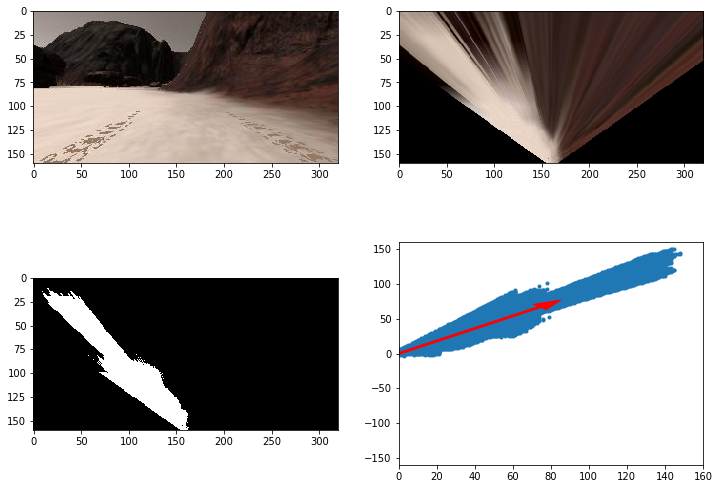

In [18]:
transformed_size = 10
source = np.float32([[15,141], [118,96], [199,96], [300,141]])
destination = np.float32([[image.shape[1]/2-transformed_size/2,image.shape[0]], 
                          [image.shape[1]/2-transformed_size/2,image.shape[0]-transformed_size], 
                          [image.shape[1]/2+transformed_size/2,image.shape[0]-transformed_size], 
                          [image.shape[1]/2+transformed_size/2,image.shape[0]]])

image = mpimg.imread('angle_example.jpg')
warped = perspect_transform(image, source, destination) # Perform perspective transform
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160)) # Threshold the warped image
xpix, ypix = rover_coords(colorsel)  # Convert to rover-centric coords
distances, angles = to_polar_coords(xpix, ypix) # Convert to polar coords
avg_angle = np.mean(angles) # Compute the average angle

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(colorsel, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(avg_angle)
y_arrow = arrow_length * np.sin(avg_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()